In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import iris
import glob
import pandas as pd
import numpy as np
import numpy.ma as ma
import cftime
from iris.util import unify_time_units
import iris.quickplot as qplt
import geopandas as gpd
import warnings
from impactstoolbox.tools import helper_functions as hf
from ffdi_variables_analysis import get_ens_df

warnings.simplefilter('ignore')

In [3]:
# Load the ensemble jobids and GWLs
ensdf = get_ens_df()

# Baseline start year
bl_start_yr = 1986

# Thresholds of FFDI
mint = 12
maxt = 24

# Root dir of the data
indir = '/scratch/hadhy/fire/ffdi_input_variables/'

ensdf

rcp8.5 gwl_1_5
rcp8.5 gwl_2
rcp8.5 gwl_4
rcp2.6 gwl_4
rcp2.6 gwl_1_5
rcp2.6 gwl_2


,rcp,hist,fut,gwl_1_5_start,gwl_2_start,gwl_4_start
0,rcp2.6,akowa,akuka,2007,2019,NaN
1,rcp2.6,akowb,akukb,2011,2037,NaN
2,rcp2.6,akowc,akukc,2023,2037,NaN
3,rcp2.6,akowe,akuke,2009,2023,NaN
4,rcp2.6,akowf,akukf,2013,2035,NaN
...,...,...,...,...,...,...
109,rcp8.5,akozl,aldsl,2013,2027,2062
110,rcp8.5,akozn,aldsn,2006,2021,2064
111,rcp8.5,akozo,aldso,2006,2020,2051
112,rcp8.5,akozp,aldsp,2006,2023,2062


In [4]:
i = 0
row = ensdf.iloc[i]
rcp = row['rcp'].replace('.', '_')

In [5]:
# Get the pre-calculated FFDI (saved as a timeseries of baseline + future, based on future ens_member_id
print('   Loading FFDI ... ', end='')
ffdi_filelist = glob.glob('/scratch/hadhy/fire/ffdi_output/'+rcp+'/ffdi_'+rcp+'_'+row['hist']+'*.nc')
ffdi_filelist.extend(glob.glob('/scratch/hadhy/fire/ffdi_output/'+rcp+'/ffdi_'+rcp+'_'+row['fut']+'*.nc'))

# Load the files into an iris cubelist
ffdi_cubes = iris.load(ffdi_filelist)  # includes baseline and future FFDI

# Remove some things to allow for the cube to be concatenated
for j in range(len(ffdi_cubes)):
    ffdi_cubes[j].remove_coord('forecast_period')
    ffdi_cubes[j].remove_coord('year')

# Now unify time coords and concatenate
unify_time_units(ffdi_cubes)
ffdi_cube = ffdi_cubes.concatenate_cube()

# Get the burnable mask
burnable = hf.get_burnable_mask(ffdi_cube)


   Loading FFDI ... 

In [6]:
# Now get FFDI variables
var_filelist = sorted(glob.glob(f"{indir}{rcp}/ffdi_input_variables_{rcp}_{row['hist']}_*"))
var_filelist.extend(sorted(glob.glob(f"{indir}{rcp}/ffdi_input_variables_{rcp}_{row['fut']}_*")))

vars = ['relative_humidity', 'soil_moisture_content_top_metre', 'precipitation_in_mpersec', 'windspeed_in_km_per_hr', 'air_temperature']

# Make a dictionary of cubes for all variables  ...
all_var_cubes = {}
for v in vars:
    print(f"   ... {v}")

    # Do all the same loading things ...
    var_cubes = iris.load(var_filelist, v)  # baseline and future variable
    for j in range(len(var_cubes)):
        for coord in ['forecast_reference_time', 'forecast_period', 'year']:
            try:
                var_cubes[j].remove_coord(coord)
            except:
                continue

    unify_time_units(var_cubes)
    all_var_cubes[v] = var_cubes.concatenate_cube()


   ... relative_humidity
   ... soil_moisture_content_top_metre
   ... precipitation_in_mpersec
   ... windspeed_in_km_per_hr
   ... air_temperature


In [7]:
# Time subset of ffdi and variables
tcon_dict = {}
# Baseline
hist_start = cftime.Datetime360Day(bl_start_yr, 1, 1)
hist_end = cftime.Datetime360Day(bl_start_yr + 20, 1, 1)
hist_tcon = iris.Constraint(time=lambda cell: hist_start <= cell.point < hist_end)
tcon_dict['Baseline'] = hist_tcon

# GWL 1.5C
gwl1p5_start = cftime.Datetime360Day(row['gwl_1_5_start'], 1, 1)
gwl1p5_end = cftime.Datetime360Day(row['gwl_1_5_start'] + 20, 1, 1)
gwl1p5_tcon = iris.Constraint(time=lambda cell: gwl1p5_start <= cell.point < gwl1p5_end)
tcon_dict['GWL1.5'] = gwl1p5_tcon

# GWL 2C
try:
    gwl2_start = cftime.Datetime360Day(row['gwl_2_start'], 1, 1)
    gwl2_end = cftime.Datetime360Day(row['gwl_2_start'] + 20, 1, 1)
    gwl2_tcon = iris.Constraint(time=lambda cell: gwl2_start <= cell.point < gwl2_end)
    tcon_dict['GWL2'] = gwl2_tcon
except:
    pass

# GWL 4C
try:
    gwl4_start = cftime.Datetime360Day(row['gwl_4_start'], 1, 1)
    gwl4_end = cftime.Datetime360Day(row['gwl_4_start'] + 20, 1, 1)
    gwl4_tcon = iris.Constraint(time=lambda cell: gwl4_start <= cell.point < gwl4_end)
    tcon_dict['GWL4'] = gwl4_tcon
except:
    pass


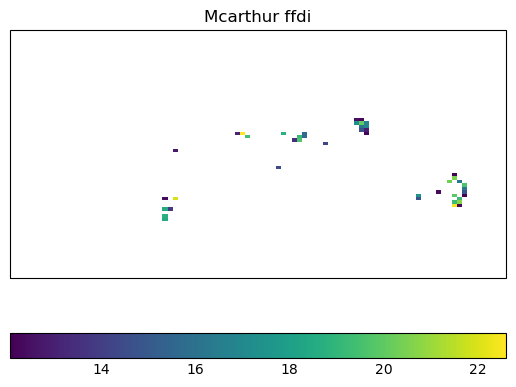

In [8]:
tcon = tcon_dict['Baseline']

# Extract the days in the time constraint
ffdi_tconned = ffdi_cube.extract(tcon)
# Combined burnable mask with masked data
burnable_allts = np.broadcast_to(ma.getmask(burnable.data), ffdi_tconned.shape)
# Mask according to the min and max thresholds
ffdi_tconned.data = ma.masked_where((ffdi_tconned.data < mint) | (ffdi_tconned.data >= maxt) | burnable_allts, ffdi_tconned.data)
fullmask = ma.getmask(ffdi_tconned.data)

qplt.pcolormesh(ffdi_tconned[0])


In [9]:
# # Get Values, time, x and y where we have data
# ### VERY SLOW ###
# # Keeping in for testing only

# myu = ffdi_tconned.coord('time').units

# d = {
#     't': [],
#     'x': [],
#     'y': [],
#     'value': [],
# }

# i = 0
# for t in range(ffdi_tconned.shape[0]):
#     for y in range(ffdi_tconned.shape[1]):
#         for x in range(ffdi_tconned.shape[2]):
#             if i > 200:
#                 break
#             if ~ma.getmask(ffdi_tconned.data[t, y, x]):
#                 d['t'].append(myu.num2date(ffdi_tconned.coord('time').points[t]))
#                 d['x'].append(ffdi_tconned.coord('longitude').points[x])
#                 d['y'].append(ffdi_tconned.coord('latitude').points[y])
#                 d['value'].append(ffdi_tconned.data[t, y, x])

#                 i = i + 1

# df = pd.DataFrame(d)
            

In [10]:
### MUCH FASTER ###

def mask2df(cube, mask_arr, varname, gwlname, ensmem, rcp, region_name='natural_earth_v5_0_0.countries_110'):
    """
    Mask the cube data using the mask, and creates a pandas dataframe using the additional metadata
    :param cube: 3D cube containing the data to be extracted and masked
    :param mask_arr: 3D numpy.ma mask (assumes mask=False for cells we want to keep)
    :param varname: variable name
    :param gwlname: global warming level name
    :param ensmem: ensemble members name
    :param rcp: RCP name
    :param region_name: could be 'ipcc' or anything accepted by regionmask. Options include all those available in regionmask: ['ar6.all', 'ar6.land', 'ar6.ocean', 'natural_earth_v5_0_0.countries_110', 'natural_earth_v5_0_0.countries_50', 'natural_earth_v5_0_0.countries_10','natural_earth_v5_0_0.land_110', 'natural_earth_v5_0_0.ocean_basins_50']
    :return: pandas dataframe
    """
    import regionmask

    cells_we_want = ~mask_arr
    value = ma.getdata(cube.data)[cells_we_want].flatten()

    myu = cube.coord('time').units
    t = cube.coord('time').points
    y = cube.coord('latitude').points
    x = cube.coord('longitude').points
    ts, ys, xs = np.meshgrid(t, y, x, sparse=False, indexing='ij')

    ts_out = ts[cells_we_want].flatten()
    xs_out = [((x + 180) % 360) - 180 for x in xs[cells_we_want].flatten()]  # Corrects for 0 to 360 problem
    ys_out = ys[cells_we_want].flatten()
    points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=xs_out, y=ys_out), crs="EPSG:4326")

    if region_name == 'ipcc':
        inshp = '/net/home/h02/hadhy/PycharmProjects/impactstoolbox/impactstoolbox/data/IPCC-WGI-reference-regions-v4.shp'
        shp = gpd.read_file(inshp, crs="epsg:4326")
    else:
        # region_name = 'natural_earth_v5_0_0.countries_110'
        regions = getattr(getattr(regionmask.defined_regions, region_name.split('.')[0]), region_name.split('.')[1])
        shp = regions.to_geodataframe()
        shp = shp.set_crs(epsg=4326, allow_override=True)

    sj = points.sjoin(shp, how="left")
    sj.reset_index(inplace=True)
    sj.drop_duplicates(subset=['index', 'geometry'], keep='first', inplace=True)

    # The most likely cause of problems could be due to the joined data not having the same number of records as
    # other records
    # print(len(xs_out))
    # print(len(sj['Acronym'].to_list()))
    if region_name == 'ipcc':
        dfout = pd.DataFrame({'t': myu.num2date(ts_out), 'x': xs_out, 'y': ys_out, 'value': value, 'var': varname,
                              'names': sj['Acronym'].to_list(), 'gwl': gwlname, 'ensemble_member': ensmem, 'rcp': rcp})  #
    else:
        dfout = pd.DataFrame({'t': myu.num2date(ts_out), 'x': xs_out, 'y': ys_out, 'value': value, 'var': varname,
                              'names': sj['names'].to_list(), 'gwl': gwlname, 'ensemble_member': ensmem,
                              'rcp': rcp})  #

    return dfout


In [11]:
# Do the masking and convert to pandas dataframe
dfout = mask2df(ffdi_tconned, fullmask, 'FFDI', 'Baseline', row['fut'], row['rcp'], region_name='natural_earth_v5_0_0.countries_110')


In [12]:
# points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=dfout['x'], y=dfout['y']), crs="EPSG:4326")
# inshp = '/net/home/h02/hadhy/PycharmProjects/impactstoolbox/impactstoolbox/data/IPCC-WGI-reference-regions-v4.shp'
# ipcc = gpd.read_file(inshp, crs="epsg:4326")

# polys = gpd.read_file('/vsicurl/https://github.com/nvkelso/natural-earth-vector/raw/master/110m_cultural/ne_110m_admin_0_countries.shp')
# # sj = gpd.sjoin(left_df=points, right_df=polys, how="left", rsuffix="grid_")
# sj = points.sjoin(ipcc, how="left")
# sj.reset_index(inplace=True)
# sj.drop_duplicates(subset=['index', 'geometry'], keep='first', inplace=True)
# # print(sj[sj.index == 49])
# # points

In [13]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# xlim = ([-100, -50])
# ylim = ([-50, 0])

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

# base = ipcc.plot(color='white', edgecolor='black', ax=ax)
# sj[sj.index == 49].plot(ax=base, marker='o', color='red', markersize=5);


In [14]:
# Loop through the time constraints and extract all the grid cells with data
dfout = {}
# for key, tcon in tcon_dict.items():
key = 'Baseline'
tcon = tcon_dict[key]
print(key)
# Extract the days in the time constraint
ffdi_tconned = ffdi_cube.extract(tcon)
# Mask according to the min and max thresholds
ffdi_tconned.data = ma.masked_where((ffdi_tconned.data < mint) | (ffdi_tconned.data >= maxt), ffdi_tconned.data)
# Do the masking and convert to pandas dataframe
tmp = mask2df(ffdi_tconned, ma.getmask(ffdi_tconned.data), 'FFDI', key, row['fut'], row['rcp'])

if isinstance(dfout, dict):
    dfout = tmp.copy()
else:
    dfout = pd.concat([dfout, tmp])

for k in all_var_cubes.keys():
    print(f"   ... {k}")
    var_tconned = all_var_cubes[k].extract(tcon)
    varout = mask2df(var_tconned, ma.getmask(ffdi_tconned.data), k, key, row['fut'], row['rcp'])
    dfout = pd.concat([dfout, varout])


Baseline
   ... relative_humidity
   ... soil_moisture_content_top_metre
   ... precipitation_in_mpersec
   ... windspeed_in_km_per_hr
   ... air_temperature


In [15]:
# dfout.reset_index(drop=True, inplace=True)
dfout

,t,x,y,value,var,names,gwl,ensemble_member,rcp
0,1986-01-01 12:00:00,-7.50,27.5,13.285952,FFDI,Algeria,Baseline,akuka,rcp2.6
1,1986-01-01 12:00:00,0.00,25.0,21.635049,FFDI,Algeria,Baseline,akuka,rcp2.6
2,1986-01-01 12:00:00,3.75,25.0,16.239558,FFDI,Algeria,Baseline,akuka,rcp2.6
3,1986-01-01 12:00:00,37.50,25.0,23.642721,FFDI,Saudi Arabia,Baseline,akuka,rcp2.6
4,1986-01-01 12:00:00,71.25,25.0,12.462291,FFDI,India,Baseline,akuka,rcp2.6
...,...,...,...,...,...,...,...,...,...
895012,2005-12-30 12:00:00,-67.50,-32.5,40.746696,air_temperature,Argentina,Baseline,akuka,rcp2.6
895013,2005-12-30 12:00:00,-60.00,-32.5,42.616447,air_temperature,Argentina,Baseline,akuka,rcp2.6
895014,2005-12-30 12:00:00,138.75,-35.0,37.947197,air_temperature,Australia,Baseline,akuka,rcp2.6
895015,2005-12-30 12:00:00,-71.25,-35.0,32.189171,air_temperature,Chile,Baseline,akuka,rcp2.6


In [16]:
odf_wide = pd.pivot_table(dfout, values="value", index=['t', 'x', 'y', 'gwl', 'names', 'ensemble_member', 'rcp'], columns=["var"])
odf_wide.reset_index(inplace=True)

In [17]:
odf_wide

var,t,x,y,gwl,names,ensemble_member,rcp,FFDI,air_temperature,precipitation_in_mpersec,relative_humidity,soil_moisture_content_top_metre,windspeed_in_km_per_hr
0,1986-01-01 12:00:00,-75.00,-15.0,Baseline,Peru,akuka,rcp2.6,20.097858,33.962364,0.003476,28.321066,136.719330,13.425830
1,1986-01-01 12:00:00,-75.00,20.0,Baseline,Cuba,akuka,rcp2.6,12.069928,34.281853,0.000000,53.150681,185.253906,29.168484
2,1986-01-01 12:00:00,-71.25,-30.0,Baseline,Chile,akuka,rcp2.6,17.845763,34.755028,0.000000,31.630552,149.937424,14.327450
3,1986-01-01 12:00:00,-67.50,-47.5,Baseline,Argentina,akuka,rcp2.6,18.491424,25.617975,0.000000,26.236513,173.923264,21.799441
4,1986-01-01 12:00:00,-67.50,-45.0,Baseline,Argentina,akuka,rcp2.6,18.794133,28.641840,0.000000,25.361774,176.505402,17.431349
...,...,...,...,...,...,...,...,...,...,...,...,...,...
874963,2005-12-30 12:00:00,123.75,-30.0,Baseline,Australia,akuka,rcp2.6,12.456396,43.472618,2.459660,40.644550,142.545334,17.026989
874964,2005-12-30 12:00:00,-56.25,-30.0,Baseline,Brazil,akuka,rcp2.6,16.439410,42.783165,0.000000,33.942234,230.300140,15.213065
874965,2005-12-30 12:00:00,-56.25,-27.5,Baseline,Paraguay,akuka,rcp2.6,15.006643,40.741478,0.000000,37.312893,238.834900,12.009656
874966,2005-12-30 12:00:00,60.00,27.5,Baseline,Iran,akuka,rcp2.6,15.895116,13.001001,0.000000,6.901413,145.040176,16.185205


In [18]:
odf_wide_ss = odf_wide.groupby(['gwl', 'names']).sample(n=10, replace=True)  # axis='index', ignore_index=True
odf_wide_ss

var,t,x,y,gwl,names,ensemble_member,rcp,FFDI,air_temperature,precipitation_in_mpersec,relative_humidity,soil_moisture_content_top_metre,windspeed_in_km_per_hr
496263,1997-07-15 12:00:00,67.50,35.0,Baseline,Afghanistan,akuka,rcp2.6,23.990343,32.080772,0.000000,22.980247,87.195854,19.234434
556558,1998-10-20 12:00:00,63.75,30.0,Baseline,Afghanistan,akuka,rcp2.6,18.410607,27.198694,0.000000,12.698873,131.468567,10.074538
139229,1989-03-30 12:00:00,63.75,30.0,Baseline,Afghanistan,akuka,rcp2.6,21.190176,31.979761,0.000000,19.003635,120.022552,14.976428
405125,1995-05-21 12:00:00,63.75,35.0,Baseline,Afghanistan,akuka,rcp2.6,20.505948,33.184441,0.000000,17.091255,159.737671,14.013552
425934,1995-10-24 12:00:00,63.75,32.5,Baseline,Afghanistan,akuka,rcp2.6,20.406155,22.738855,0.000000,14.516840,134.338226,13.459466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
424647,1995-10-16 12:00:00,30.00,-20.0,Baseline,Zimbabwe,akuka,rcp2.6,15.856053,36.039299,1.093657,35.280392,90.904663,10.555511
296968,1992-10-15 12:00:00,30.00,-20.0,Baseline,Zimbabwe,akuka,rcp2.6,13.442631,32.764305,0.000000,38.051834,89.368614,12.426204
377697,1994-09-22 12:00:00,30.00,-17.5,Baseline,Zimbabwe,akuka,rcp2.6,14.809700,33.464073,0.000000,34.976383,85.017578,10.909586
506715,1997-09-18 12:00:00,30.00,-17.5,Baseline,Zimbabwe,akuka,rcp2.6,13.355095,32.226433,0.000000,35.363091,85.017456,8.849301


In [6]:
odf_wide_ss = pd.read_csv('/net/data/users/hadhy/ESMS/fire_paper/data/odf_bigdata_12_to_24_temp2.csv')

In [ ]:
odf_wide_ss2 = odf_wide_ss.groupby(['gwl', 'names']).sample(n=100, replace=True)  # axis='index', ignore_index=True

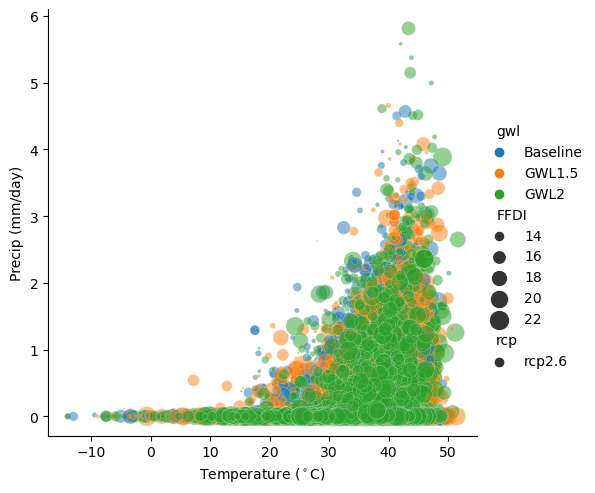

In [37]:
# vars = ['relative_humidity', 'soil_moisture_content_top_metre', 'precipitation_in_mpersec', 'windspeed_in_km_per_hr', 'air_temperature']
import seaborn as sns
import matplotlib.pyplot as plt

# g = sns.relplot(data=odf_wide_ss, x='air_temperature', y='precipitation_in_mpersec', hue='gwl', col='ipcc', col_wrap=3, size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
g = sns.relplot(data=odf_wide_ss, x='air_temperature', y='precipitation_in_mpersec', hue='gwl', size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template='{col_name}')
g.set_axis_labels(x_var="Temperature ($^\circ$C)", y_var="Precip (mm/day)")

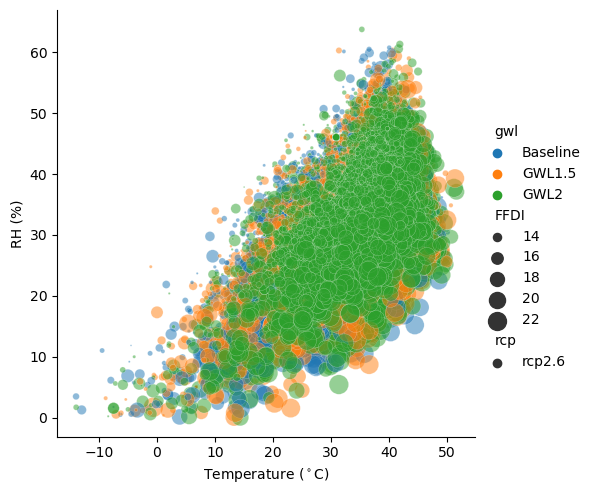

In [38]:
g = sns.relplot(data=odf_wide_ss, x='air_temperature', y='relative_humidity', hue='gwl', size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template='{col_name}')
g.set_axis_labels(x_var="Temperature ($^\circ$C)", y_var="RH (%)")

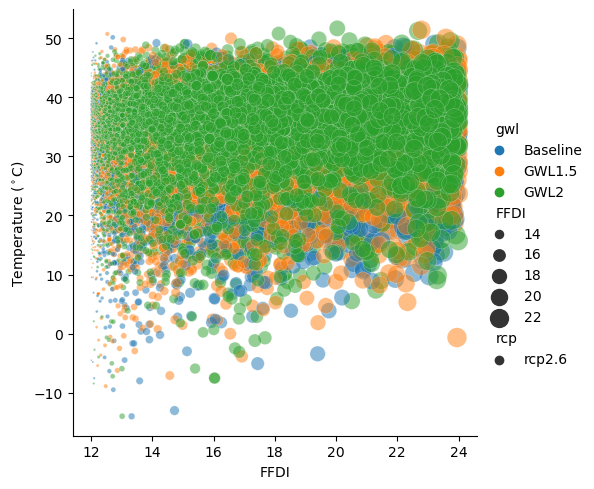

In [39]:
g = sns.relplot(data=odf_wide_ss, x='FFDI', y='air_temperature', hue='gwl', size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template='{col_name}')
g.set_axis_labels(x_var="FFDI", y_var="Temperature ($^\circ$C)")

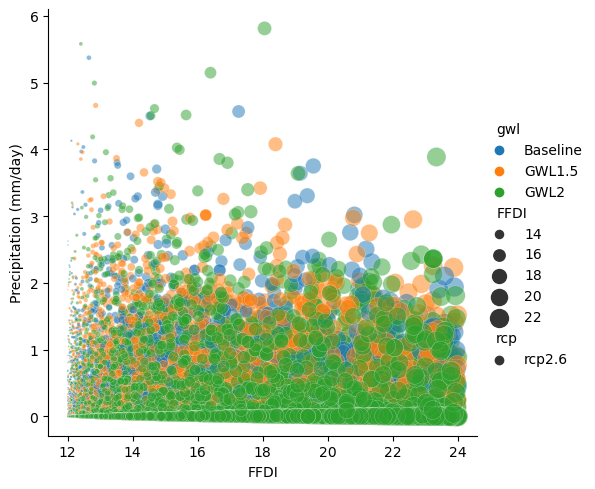

In [45]:
g = sns.relplot(data=odf_wide_ss, x='FFDI', y='precipitation_in_mpersec', hue='gwl', size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template='{col_name}')
g.set_axis_labels(x_var="FFDI", y_var="Precipitation (mm/day)")

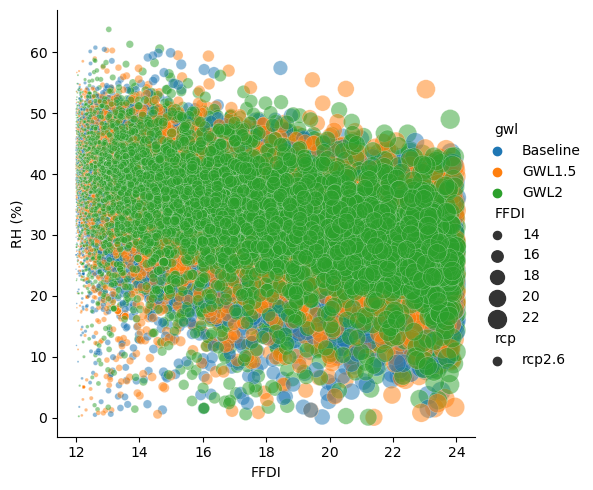

In [40]:
g = sns.relplot(data=odf_wide_ss, x='FFDI', y='relative_humidity', hue='gwl', size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template='{col_name}')
g.set_axis_labels(x_var="FFDI", y_var="RH (%)")

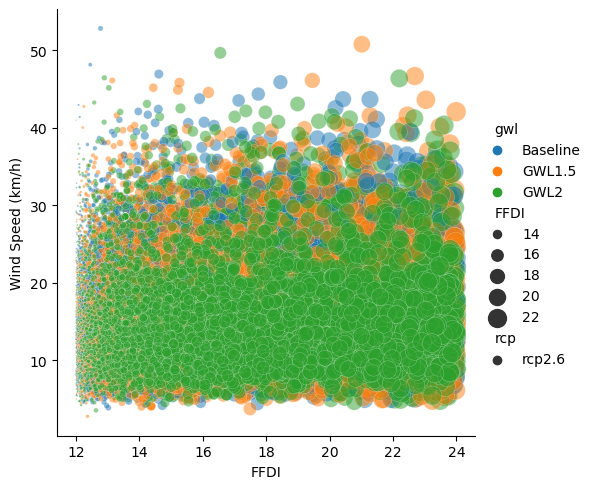

In [41]:
g = sns.relplot(data=odf_wide_ss, x='FFDI', y='windspeed_in_km_per_hr', hue='gwl', size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template='{col_name}')
g.set_axis_labels(x_var="FFDI", y_var="Wind Speed (km/h)")

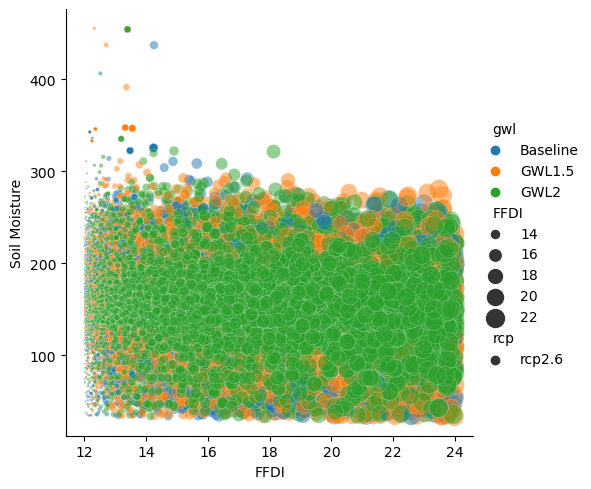

In [42]:
g = sns.relplot(data=odf_wide_ss, x='FFDI', y='soil_moisture_content_top_metre', hue='gwl', size='FFDI', sizes=(1,200), style='rcp', alpha=.5, kind='scatter', hue_order=tcon_dict.keys())  # col='Country',
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template='{col_name}')
g.set_axis_labels(x_var="FFDI", y_var="Soil Moisture")

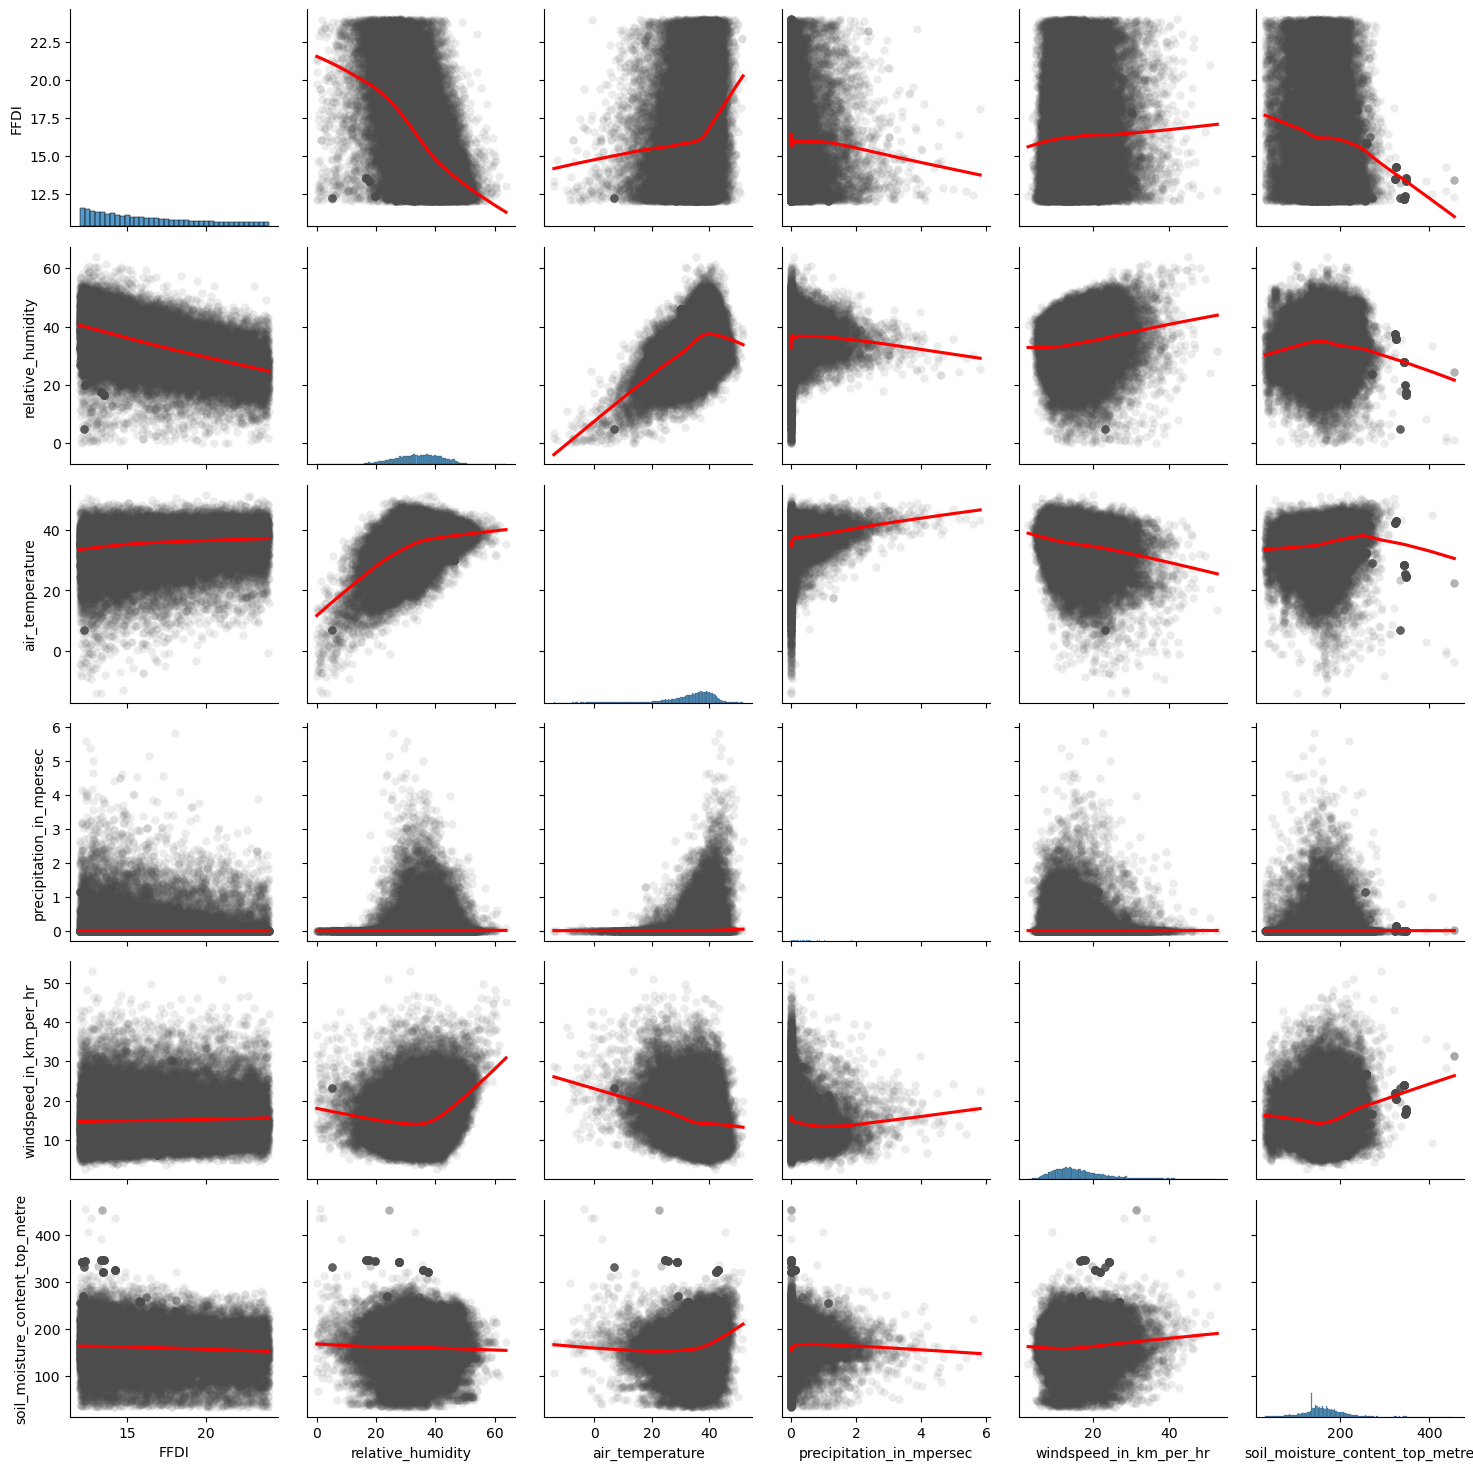

In [44]:
g = sns.PairGrid(odf_wide_ss, vars=['FFDI', 'relative_humidity', 'air_temperature', 'precipitation_in_mpersec', 'windspeed_in_km_per_hr', 'soil_moisture_content_top_metre'])
g.map_diag(sns.histplot)
g.map_offdiag(sns.regplot, color=".3", lowess=True, line_kws=dict(color="r"), scatter_kws=dict(alpha=0.1, linewidth=0))

In [ ]:
To do:
- Don't do by IPCC region, do by country instead
- Remove non-burnable area
- Sample again
- Plots:
    - Plot matrix by country for all gwls 
    - Chloropleth map of baseline vs 1.5 vs 2 vs 4